In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consumer-complaint-database/rows.csv


In [1]:
import os
print(os.listdir("../input"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

['consumer-complaint-database']


In [2]:
df = pd.read_csv('/kaggle/input/consumer-complaint-database/rows.csv',low_memory=False)
df.shape

(1282355, 18)

In [3]:
df.head(2).T

,0,1
Date received,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account
Sub-product,Checking account,Other banking product or service
Issue,Managing an account,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION
State,FL,WA
ZIP code,328XX,98204


In [4]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(383564, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

29.9

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

In [7]:
df2 = df1.sample(10000, random_state=1).copy()


In [8]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, credit repair services, or o..."
1,Debt collection
2,Consumer Loan
3,Credit card
4,Credit card or prepaid card
5,Mortgage
6,Credit reporting
7,Vehicle loan or lease
8,Student loan
9,"Payday loan, title loan, or personal loan"


In [9]:
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, credit repair services, or o...",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, credit repair services, or o...",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card,I have a XXXX BIG card and made my payment whe...,3


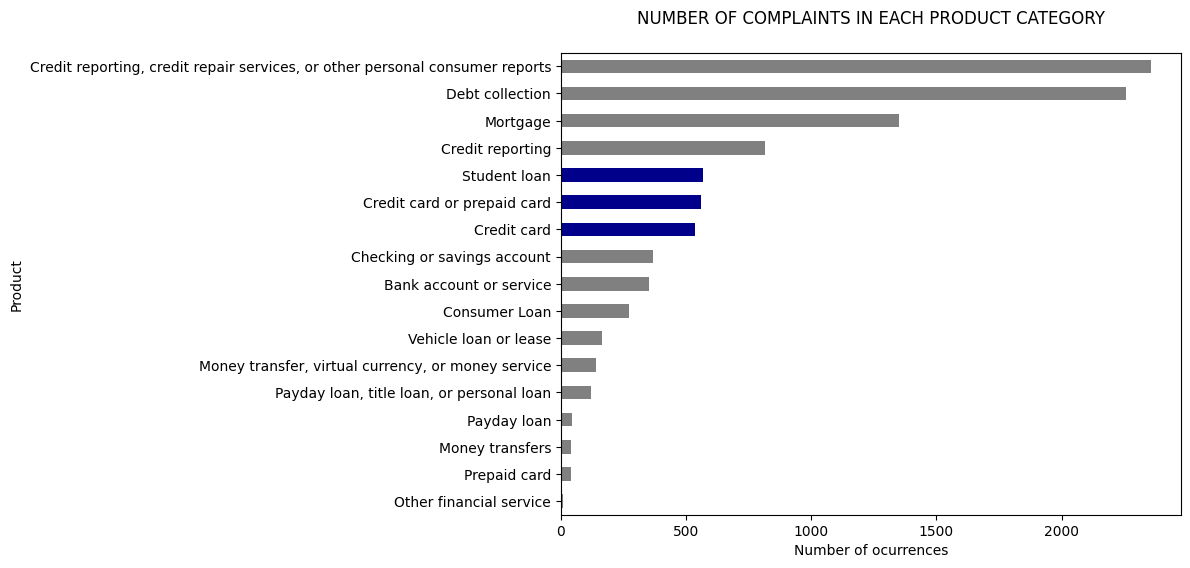

In [10]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [12]:
from sklearn.feature_selection import chi2

N = 3
for Tag, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    # ✅ Use get_feature_names_out instead of get_feature_names
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print(f"\n==> {Tag}:")
    print("  * Most Correlated Unigrams are: %s" % ', '.join(unigrams[-N:]))
    print("  * Most Correlated Bigrams are: %s" % ', '.join(bigrams[-N:]))



==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance

==> Credit card:
  * Most Correlated Unigrams are: amex, macy, card
  * Most Correlated Bigrams are: synchrony bank, american express, credit card

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: merchant, limit, card
  * Most Correlated Bigrams are: credit limit, card xx, credit card

==> Credit reporting:
  * Most Correlated Unigrams are: experian, transunion, equifax
  * Most Correlated Bigrams are: gone past, disputed resolve, verify accounts

==> Credit reporting, credit

In [13]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [14]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc


,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.6843,0.007488
LogisticRegression,0.6705,0.010216
MultinomialNB,0.5417,0.004618
RandomForestClassifier,0.4616,0.004992


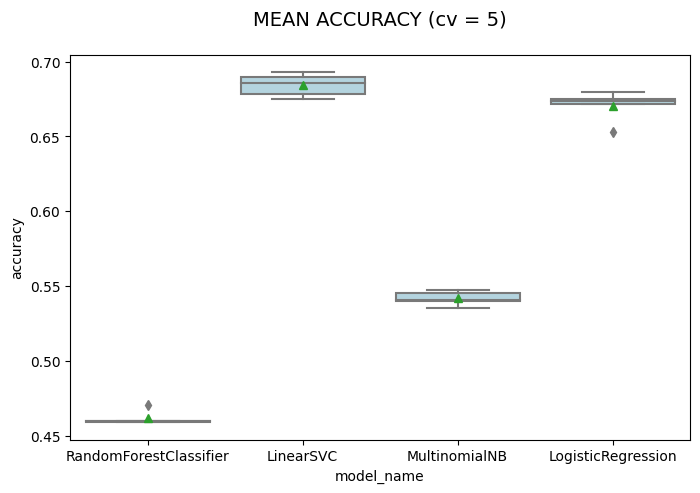

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [17]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.64      0.76      0.70       569
                                                             Debt collection       0.74      0.82      0.78       588
                                                               Consumer Loan       0.57      0.29      0.38        73
                                                                 Credit card       0.49      0.47      0.48       126
                                                 Credit card or prepaid card       0.49      0.52      0.51       117
                                                                    Mortgage       0.85      0.93      0.88       340
                                                            Credit reporting       0.56      0.34      0.42       214
                          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


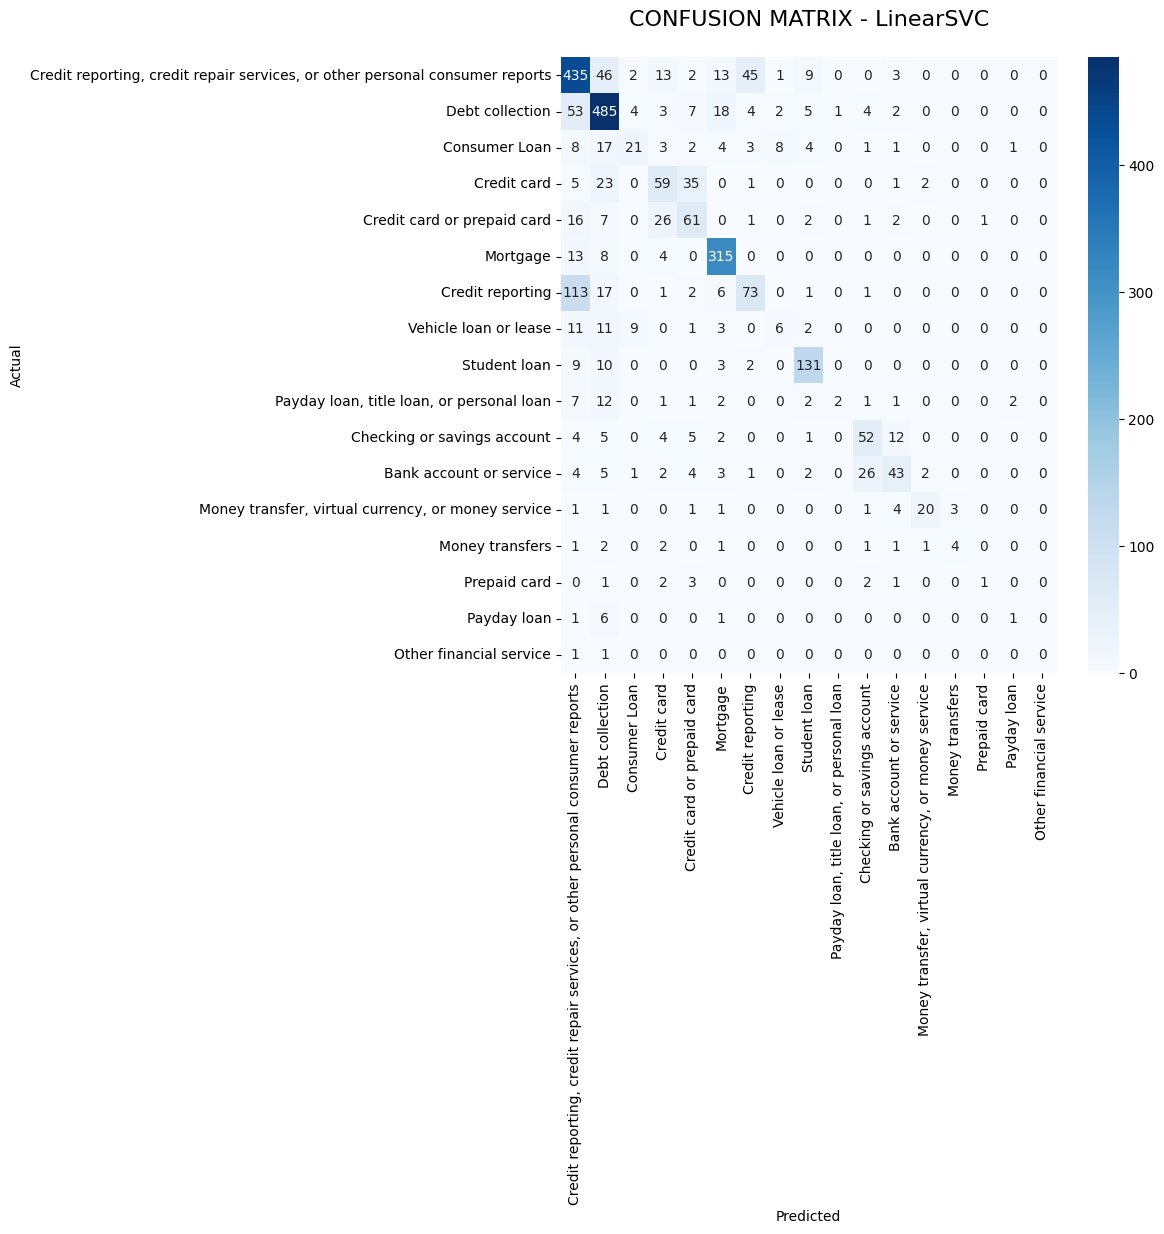

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [20]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 53 examples.


,Product,Consumer_complaint
111807,Debt collection,I am writing to dispute the inaccurate data be...
376788,Debt collection,check n ' Go payday loan made me a loan and th...
570764,Debt collection,THIS AMT OWED {$8800.00} WAS TO BE PAID UNDER ...
88089,Debt collection,I am submitting this complaint for an account ...
530825,Debt collection,There is a payday loan that is currently now b...
487131,Debt collection,Thia.debt collectionnagency has reported inacc...
301391,Debt collection,"Today is XX/XX/XXXX, I have not receive a lett..."
381692,Debt collection,Why is this still on my credit file still. I w...
155187,Debt collection,Equifax reply meet FCRA requirement as and exp...
238609,Debt collection,I have no knowledge of these accounts



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 113 examples.


,Product,Consumer_complaint
609473,Credit reporting,"Since XX/XX/XXXX, I have been requesting from ..."
561244,Credit reporting,XXXX inquiries were made to my Transunion cred...
713873,Credit reporting,TransUnion had an incorrect item deleted from ...
561330,Credit reporting,Equifax is showing late payment for my mortgag...
533824,Credit reporting,original case # XXXX was resolved except for t...
...,...,...
723283,Credit reporting,I disputed the item with all of the agencies. ...
522107,Credit reporting,I mailed a Multiple Inquiry Removal Letter on ...
683039,Credit reporting,Transunion had a glitch in their system when I...
620327,Credit reporting,Noticed some fraudulent stuff on my credit rep...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 46 examples.


,Product,Consumer_complaint
167717,"Credit reporting, credit repair services, or o...",When my vehicle was repossessed in XX/XX/2017 ...
486427,"Credit reporting, credit repair services, or o...",On X/X/17 I called XXXX XXXX XXXX ...
131925,"Credit reporting, credit repair services, or o...",I submitted a dispute online on a debt with XX...
370575,"Credit reporting, credit repair services, or o...",Credit reporting agency incorrectly keeps repo...
395164,"Credit reporting, credit repair services, or o...","Hi, I 'm submitting this claim against Experia..."
301509,"Credit reporting, credit repair services, or o...",While attempting to get approval for a loan to...
404336,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I sent a letter to Wakefield & A...
418391,"Credit reporting, credit repair services, or o...","loans show up on my report and its not mine, i..."
310415,"Credit reporting, credit repair services, or o...","Portfolio Recov Assoc, Promise to remove the c..."
347164,"Credit reporting, credit repair services, or o...",XXXX Inquired because someone is trying to use...



'Credit card' predicted as 'Debt collection' : 23 examples.


,Product,Consumer_complaint
895086,Credit card,I pay all my bills in full every month. I have...
681770,Credit card,I sent the following message to Capital One on...
544109,Credit card,To Whom May Concern : Early Spring XX/XX/XXXX ...
859065,Credit card,I had several attempts to get information abou...
723669,Credit card,The Sychrony issued excessive credit to me thr...
872562,Credit card,I used a debt relief agency to pay my debts ( ...
609682,Credit card,I have a letter stating from American Express ...
685144,Credit card,Someone stole my identity and used it to open ...
907179,Credit card,I keep getting a robo call ( XXXX ) threatenin...
584221,Credit card,Chase Bank has a fraudulent credit card listed...



'Credit card or prepaid card' predicted as 'Credit card' : 26 examples.


,Product,Consumer_complaint
332957,Credit card or prepaid card,.I have a credit card with XXXX XXXX which is ...
330939,Credit card or prepaid card,Two years ago I had a lot of XXXX work done at...
128917,Credit card or prepaid card,My Daughter purchased a bed from XXXX sleep wi...
248874,Credit card or prepaid card,"I am a longstanding Bank of America, XXXX XXXX..."
56799,Credit card or prepaid card,"Dear CFPB, I am a loyal Discover Card Holder s..."
500275,Credit card or prepaid card,When my husband and I attempted to apply for a...
124473,Credit card or prepaid card,My family ( XXXX travelers ) traveled from Wa...
62304,Credit card or prepaid card,I received a text message at XXXX PST stating ...
391742,Credit card or prepaid card,American Express mistakenly closed my credit c...
68810,Credit card or prepaid card,This is in regards to my XXXX XXXX credit car...



'Credit card' predicted as 'Credit card or prepaid card' : 35 examples.


,Product,Consumer_complaint
672012,Credit card,I was shocked when I reviewed my credit report...
549675,Credit card,I found a fraudulent charge of {$43.00} on my ...
559348,Credit card,On XX/XX/2017 I was in contact with Kohl 's. I...
808504,Credit card,I signed up for a XXXX through TD Bank under p...
660765,Credit card,Capital One recently canceled my credit card w...
733469,Credit card,"Hello, I am asking that you investigate this p..."
772340,Credit card,After month 's of a barrage of marketing mater...
684174,Credit card,I opened a Care Credit account. I was told tha...
520307,Credit card,A Bank of America credit analyst agreed to ope...
659338,Credit card,A US Bank agent called me and said ( paraphras...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 45 examples.


,Product,Consumer_complaint
238211,"Credit reporting, credit repair services, or o...",THIS IS ON MY EXPERIAN ACCOUNT ( 1 ) XXXX XXXX...
230592,"Credit reporting, credit repair services, or o...",I received an alert via email from Experian le...
379540,"Credit reporting, credit repair services, or o...",In XXXX and again XXXX my identity was stolen....
226543,"Credit reporting, credit repair services, or o...",I sent a letter to Equifax requesting them to ...
264990,"Credit reporting, credit repair services, or o...",I submitted a dispute with Experian regarding ...
476556,"Credit reporting, credit repair services, or o...",I mailed certified letter off to Experian and ...
471348,"Credit reporting, credit repair services, or o...",some inquiries were removed from my credit rep...
140125,"Credit reporting, credit repair services, or o...",I applied for an apartment on XX/XX/XXXX. I de...
283368,"Credit reporting, credit repair services, or o...",I formerly requested that both XXXX and XXXX r...
409693,"Credit reporting, credit repair services, or o...",Collection account that is reporting on Transu...



'Bank account or service' predicted as 'Checking or savings account' : 26 examples.


,Product,Consumer_complaint
655179,Bank account or service,My email is XXXXXXXXXXXX and I never got to pr...
540543,Bank account or service,HSBC refuses to confirm the date my account wa...
655963,Bank account or service,Bank of America has charged me numerous XXXX f...
593920,Bank account or service,My complaint is with Capital One 360 ; they do...
692350,Bank account or service,"My name is XXXX, I am my father 's heir & the ..."
760899,Bank account or service,I have a XXXX IRA with Capital One 360. My mob...
674009,Bank account or service,"On XXXX XXXX 2016, I 'd visited the Wells Farg..."
541558,Bank account or service,On XXXX my husband deposited {$400.00} through...
547387,Bank account or service,"On XX/XX/XXXX, a merchant presented an electro..."
641764,Bank account or service,I have a Health Savings Account with Wells Far...


In [22]:
from sklearn.feature_selection import chi2

N = 4
for Tag, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print(f"\n==> {Tag}:")
    print("  * Most Correlated Unigrams are: %s" % ', '.join(unigrams[-N:]))
    print("  * Most Correlated Bigrams are: %s" % ', '.join(bigrams[-N:]))



==> Bank account or service:
  * Most Correlated Unigrams are: deposit, overdraft, bank, scottrade
  * Most Correlated Bigrams are: 00 overdraft, citigold checking, debit card, checking account

==> Checking or savings account:
  * Most Correlated Unigrams are: deposit, checking, branch, overdraft
  * Most Correlated Bigrams are: savings account, 00 bonus, overdraft fees, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: dealer, dealership, vehicle, car
  * Most Correlated Bigrams are: title vehicle, car loan, vehicle loan, regional acceptance

==> Credit card:
  * Most Correlated Unigrams are: express, amex, macy, card
  * Most Correlated Bigrams are: using card, synchrony bank, american express, credit card

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: capital, merchant, limit, card
  * Most Correlated Bigrams are: capital credit, credit limit, card xx, credit card

==> Credit reporting:
  * Most Correlated Unigrams are: report, experian, t

In [26]:
print(df2.columns)



Index(['Product', 'Consumer_complaint', 'category_id'], dtype='object')


In [27]:
X = df2['Consumer_complaint']  # Use the actual column name
y = df2['category_id']


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# 1. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# 2. TF-IDF Vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
X_train_vectorized = fitted_vectorizer.transform(X_train)

# 3. Model Training
model = LinearSVC().fit(X_train_vectorized, y_train)

In [29]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

[8]


In [30]:
df2[df2['Consumer_complaint'] == new_complaint]

,Product,Consumer_complaint,category_id
877489,Student loan,I have been enrolled back at XXXX XXXX Univers...,8


In [31]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

[0]


In [32]:
df2[df2['Consumer_complaint'] == new_complaint_2]


,Product,Consumer_complaint,category_id
420821,"Credit reporting, credit repair services, or o...",Equifax exposed my personal information withou...,0
